<a href="https://colab.research.google.com/github/ktshih/ktshih_64061/blob/main/Assignment%202/Shih_Assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Mounting Google Drive
# Using the Google Drive icon at the top of file file navigation panel
# or uncomment the code below and run

# drive.mount('/content/drive')

# Unzip data from zip file stored in Google Drive to local (tempoary) folder /content

!unzip -qq /content/drive/MyDrive/Upload/KSUMPH/MIS64061/PYLibrary/train.zip -d /content

In [4]:
# Parameters

NSample_train = 3000
NSample_val = 500
NSample_test = 500


# Copying images to training, validation, and test directories

import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=NSample_train)
make_subset("validation", start_index=NSample_train, end_index=(NSample_train+NSample_val))
make_subset("test", start_index=(NSample_train+NSample_val), end_index=(NSample_train+NSample_val+NSample_test))

# Using image_dataset_from_directory to read images

from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 6000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [5]:
# Import keras library
from tensorflow import keras
from tensorflow.keras import layers

Epoch 1/30
188/188 [==============================] - 19s 49ms/step - loss: 0.6877 - accuracy: 0.5225 - val_loss: 0.6551 - val_accuracy: 0.5630
Epoch 2/30
188/188 [==============================] - 9s 47ms/step - loss: 0.6671 - accuracy: 0.5888 - val_loss: 0.6328 - val_accuracy: 0.6300
Epoch 3/30
188/188 [==============================] - 9s 46ms/step - loss: 0.6232 - accuracy: 0.6413 - val_loss: 0.6227 - val_accuracy: 0.6540
Epoch 4/30
188/188 [==============================] - 9s 46ms/step - loss: 0.5867 - accuracy: 0.6863 - val_loss: 0.5990 - val_accuracy: 0.6700
Epoch 5/30
188/188 [==============================] - 9s 46ms/step - loss: 0.5488 - accuracy: 0.7253 - val_loss: 0.5270 - val_accuracy: 0.7330
Epoch 6/30
188/188 [==============================] - 9s 46ms/step - loss: 0.5107 - accuracy: 0.7502 - val_loss: 0.5079 - val_accuracy: 0.7560
Epoch 7/30
188/188 [==============================] - 9s 46ms/step - loss: 0.4676 - accuracy: 0.7778 - val_loss: 0.4920 - val_accuracy: 0.759

'/content/drive/MyDrive/Upload/KSUMPH/MIS64061/PYLibrary/Colab/20221020-123933'

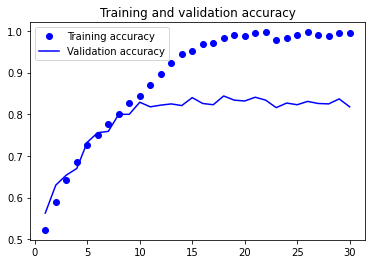

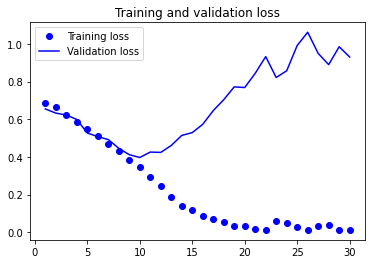

In [6]:
# Baseline:
# Instantiating a small convnet as Baseline architecture
# 5 layers of Conv2D, 
# with a layer of MaxPolling2D in between each Conv2D layer

# Parameters
NEpoch = 30

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)  # Normalizing pixel values
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)   # Flattening 2D convnet to 1D for output
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

# Configuring the model for training
# Using "adam" instead of "rmsprop" optimizer

model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])


# Fitting the model Baseline
# Using callbacks to save best results to be loaded for use later

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=NEpoch,
    validation_data=validation_dataset,
    callbacks=callbacks)


# Displaying curves of loss and accuracy during training

import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)

plt.figure()
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
fig1 = plt.gcf()
pngName = "Baseline_accuracy.png"
fig1.savefig(pngName)

plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
fig2 = plt.gcf()
pngName = "Baseline_loss.png"
fig2.savefig(pngName)


# Evaluating the model Baseline on the test set

test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)

import time
timestr = time.strftime("%Y%m%d-%H%M%S")
import contextlib
file_path = 'stdout.txt'
with open(file_path, "a") as o:
    with contextlib.redirect_stdout(o):
        print(f"stdout file written time: {timestr}")
        print(f"NSample_train={NSample_train}")
        print(f"NEpoch={NEpoch}")
        print(f"Baseline Test accuracy: {test_acc:.3f}")


# Copying output files to Google Drive
GDrivePath = "/content/drive/MyDrive/Upload/KSUMPH/MIS64061/PYLibrary/Colab"

import time
timestr = time.strftime("%Y%m%d-%H%M%S")

import os, shutil, glob
os.mkdir(timestr)
shutil.move("stdout.txt", timestr)
pngFiles = glob.glob("*.png")
for f in pngFiles: shutil.move(f, timestr)
shutil.move(timestr, GDrivePath)

Epoch 1/100
188/188 [==============================] - 14s 68ms/step - loss: 0.6947 - accuracy: 0.5138 - val_loss: 0.7107 - val_accuracy: 0.5000
Epoch 2/100
188/188 [==============================] - 13s 66ms/step - loss: 0.6847 - accuracy: 0.5378 - val_loss: 0.6599 - val_accuracy: 0.5860
Epoch 3/100
188/188 [==============================] - 13s 66ms/step - loss: 0.6629 - accuracy: 0.5760 - val_loss: 0.6352 - val_accuracy: 0.6010
Epoch 4/100
188/188 [==============================] - 13s 66ms/step - loss: 0.6380 - accuracy: 0.6368 - val_loss: 0.6262 - val_accuracy: 0.6550
Epoch 5/100
188/188 [==============================] - 13s 66ms/step - loss: 0.6259 - accuracy: 0.6547 - val_loss: 0.5990 - val_accuracy: 0.6490
Epoch 6/100
188/188 [==============================] - 13s 66ms/step - loss: 0.5872 - accuracy: 0.6868 - val_loss: 0.5658 - val_accuracy: 0.7130
Epoch 7/100
188/188 [==============================] - 13s 66ms/step - loss: 0.5575 - accuracy: 0.7140 - val_loss: 0.5820 - val_ac

'/content/drive/MyDrive/Upload/KSUMPH/MIS64061/PYLibrary/Colab/20221020-143619'

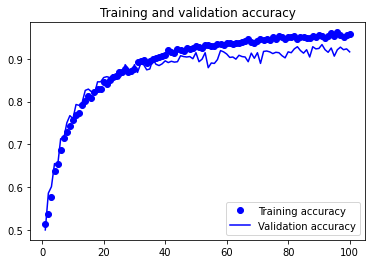

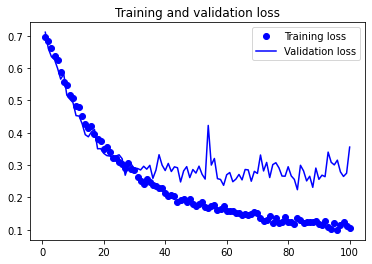

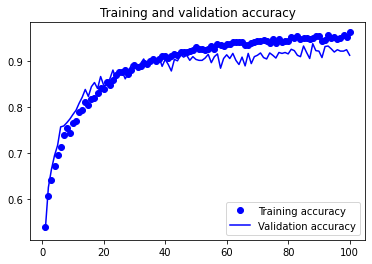

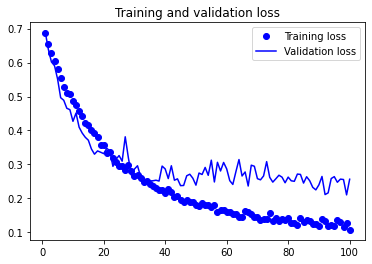

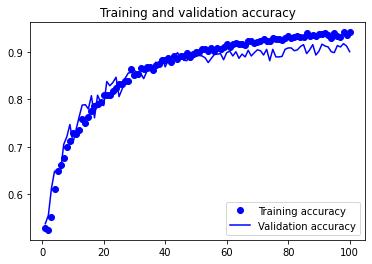

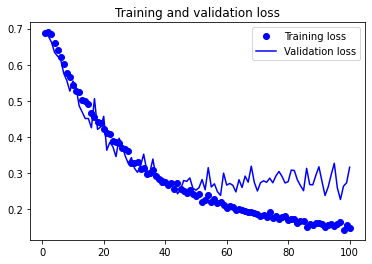

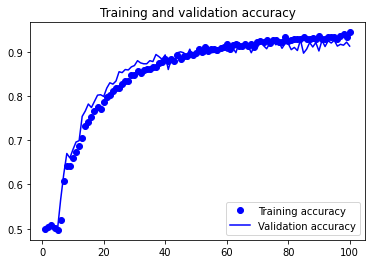

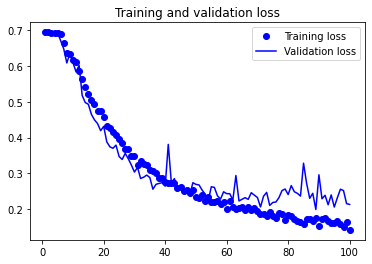

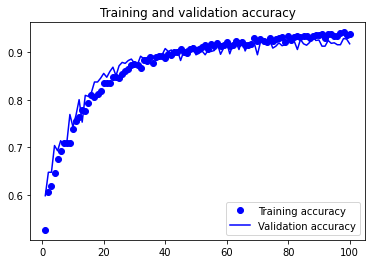

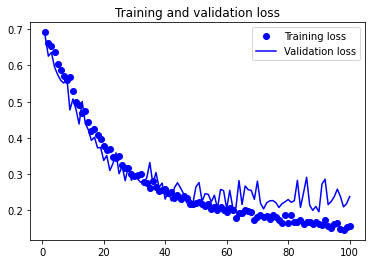

In [7]:
# Method #1 Augmentation

# Parameters
DropoutRates = [0.3, 0.4, 0.5, 0.6, 0.7]
NEpoch = 100


# Define a data augmentation stage to add to an image model
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)


# Defining a new convnet that includes image augmentation and dropout
results = list()
for d in DropoutRates:
  keras.backend.clear_session()
  inputs = keras.Input(shape=(180, 180, 3))
  x = data_augmentation(inputs)   # augumentation stage added here
  x = layers.Rescaling(1./255)(x)
  x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
  x = layers.MaxPooling2D(pool_size=2)(x)
  x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
  x = layers.MaxPooling2D(pool_size=2)(x)
  x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
  x = layers.MaxPooling2D(pool_size=2)(x)
  x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
  x = layers.MaxPooling2D(pool_size=2)(x)
  x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
  x = layers.Flatten()(x)
  x = layers.Dropout(d)(x)    # dropout layer added here
  outputs = layers.Dense(1, activation="sigmoid")(x)
  model = keras.Model(inputs=inputs, outputs=outputs)

  # Using "adam" instead of "rmsprop" optimizer
  model.compile(loss="binary_crossentropy",
                optimizer="adam",
                metrics=["accuracy"])

  # Training the regularized convnet for 100 epochs
  callbacks = [
      keras.callbacks.ModelCheckpoint(
          filepath="convnet_from_scratch_with_augmentation.keras",
          save_best_only=True,
          monitor="val_loss")
  ]
  history = model.fit(
      train_dataset,
      epochs=NEpoch,
      validation_data=validation_dataset,
      callbacks=callbacks)


  # Saving the results
  results.append([history.history["accuracy"],
                 history.history["val_accuracy"],
                 history.history["loss"],
                 history.history["val_loss"]]
  )

  # Evaluating the model on the test set
  test_model = keras.models.load_model(
      "convnet_from_scratch_with_augmentation.keras")
  test_loss, test_acc = test_model.evaluate(test_dataset)

  import time
  timestr = time.strftime("%Y%m%d-%H%M%S")
  import contextlib
  file_path = 'stdout.txt'
  with open(file_path, "a") as o:
      with contextlib.redirect_stdout(o):
          print(f"stdout file written time: {timestr}")
          print(f"NSampe_train={NSample_train}")
          print(f"NEpoch={NEpoch}")
          print(f"DropoutRate={d:.1f}")
          print(f"Method #1 Augmentation (train from scratch) Test accuracy: {test_acc:.3f}")


# Plotting the results
import matplotlib.pyplot as plt

for i, d in enumerate(DropoutRates):
  result = results[i]
  acc = result[0]
  val_acc = result[1]
  loss = result[2]
  val_loss = result[3]
  epochs = range(1, len(acc) + 1)

  plt.figure()
  plt.plot(epochs, acc, "bo", label="Training accuracy")
  plt.plot(epochs, val_acc, "b", label="Validation accuracy")
  plt.title("Training and validation accuracy")
  plt.legend()
  fig1 = plt.gcf()
  pngName = f"Method1_D({d:.1f})_accuracy.png"
  fig1.savefig(pngName)
  plt.figure()
  plt.plot(epochs, loss, "bo", label="Training loss")
  plt.plot(epochs, val_loss, "b", label="Validation loss")
  plt.title("Training and validation loss")
  plt.legend()
  fig2 = plt.gcf()
  pngName = f"Method1_D({d:.1f})_loss.png"
  fig2.savefig(pngName)


# Copying outpot files to Google Drive
GDrivePath = "/content/drive/MyDrive/Upload/KSUMPH/MIS64061/PYLibrary/Colab"

import time
timestr = time.strftime("%Y%m%d-%H%M%S")

import os, shutil, glob
os.mkdir(timestr)
shutil.move("stdout.txt", timestr)
pngFiles = glob.glob("*.png")
for f in pngFiles: shutil.move(f, timestr)
shutil.move(timestr, GDrivePath)

In [ ]:
# Method #2 Pre-trained model with
#           redefine and retrain classifier using features from pretrained data set 

# Instantiating the VGG16 convolutional base
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))


# Extracting the VGG16 features and corresponding labels using dogs vs cats data set
import numpy as np
def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)


# Defining and training the densely connected classifier for 20 epochs
results = list()
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

# Using "adam" instead of "rmsprop" optimizer
model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

# Training for 20 epochs
callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="feature_extraction.keras",
      save_best_only=True,
      monitor="val_loss")
]
history = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)


# Saving the results
results.append([history.history["accuracy"],
                history.history["val_accuracy"],
                history.history["loss"],
                history.history["val_loss"]]
)


# Evaluating the model on the test set
test_model = keras.models.load_model(
    "feature_extraction.keras")
test_loss, test_acc = test_model.evaluate(test_features, test_labels)

import time
timestr = time.strftime("%Y%m%d-%H%M%S")
import contextlib
file_path = 'stdout.txt'
with open(file_path, "a") as o:
    with contextlib.redirect_stdout(o):
        print(f"stdout file written time: {timestr}")
        print(f"NSampe_train={NSample_train}")
        print(f"Method #2 Pretrained (only retrained classifier) Test accuracy: {test_acc:.3f}")


# Plotting the results
import matplotlib.pyplot as plt

result = results[0]
acc = result[0]
val_acc = result[1]
loss = result[2]
val_loss = result[3]
epochs = range(1, len(acc) + 1)

plt.figure()
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
fig1 = plt.gcf()
pngName = f"Method2_accuracy.png"
fig1.savefig(pngName)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
fig2 = plt.gcf()
pngName = f"Method2_loss.png"
fig2.savefig(pngName)


# Copying outpot files to Google Drive
GDrivePath = "/content/drive/MyDrive/Upload/KSUMPH/MIS64061/PYLibrary/Colab"

import time
timestr = time.strftime("%Y%m%d-%H%M%S")

import os, shutil, glob
os.mkdir(timestr)
shutil.move("stdout.txt", timestr)
pngFiles = glob.glob("*.png")
for f in pngFiles: shutil.move(f, timestr)
shutil.move(timestr, GDrivePath)

In [ ]:
# Method #3 Pretained model with
#           freezed conv_base, retrained classifier, and augmentation

# Parameters
DropoutRates = [0.3, 0.4, 0.5, 0.6, 0.7]
# d = DropoutRates[0]
NEpoch = 50

# Instantiating and freezing the VGG16 convolutional base
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
conv_base.trainable = False

# Adding a data augmentation stage and a classifier to the convolutional base
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)


# Defining a new convnet using conv_base that includes image augmentation and dropout
results = list()
for d in DropoutRates:
  keras.backend.clear_session()
  inputs = keras.Input(shape=(180, 180, 3))
  x = data_augmentation(inputs)
  x = keras.applications.vgg16.preprocess_input(x)
  x = conv_base(x)
  x = layers.Flatten()(x)
  x = layers.Dense(256)(x)
  x = layers.Dropout(d)(x)
  outputs = layers.Dense(1, activation="sigmoid")(x)
  model = keras.Model(inputs, outputs)

  model.compile(loss="binary_crossentropy",
                optimizer="adam",
                metrics=["accuracy"])


  # Training the convnet with dogs vs cats data for 50 epochs
  callbacks = [
      keras.callbacks.ModelCheckpoint(
          filepath="feature_extraction_with_data_augmentation.keras",
          save_best_only=True,
          monitor="val_loss")
  ]
  history = model.fit(
      train_dataset,
      epochs=NEpoch,
      validation_data=validation_dataset,
      callbacks=callbacks)


  # Saving the results
  results.append([history.history["accuracy"],
                  history.history["val_accuracy"],
                  history.history["loss"],
                  history.history["val_loss"]]
  )


  # Evaluating the model on the test set
  test_model = keras.models.load_model(
      "feature_extraction_with_data_augmentation.keras")
  test_loss, test_acc = test_model.evaluate(test_dataset)

  import time
  timestr = time.strftime("%Y%m%d-%H%M%S")
  import contextlib
  file_path = 'stdout.txt'
  with open(file_path, "a") as o:
      with contextlib.redirect_stdout(o):
          print(f"stdout file written time: {timestr}")
          print(f"NSampe_train={NSample_train}")
          print(f"NEpoch={NEpoch}")
          print(f"DropoutRate={d}")
          print(f"Method #3 Pretrained (freezed conv_base & augmentation) Test accuracy: {test_acc:.3f}")


# Plotting the results
import matplotlib.pyplot as plt
for d in DropoutRates:
  result = results[0]
  acc = result[0]
  val_acc = result[1]
  loss = result[2]
  val_loss = result[3]
  epochs = range(1, len(acc) + 1)

  plt.figure()
  plt.plot(epochs, acc, "bo", label="Training accuracy")
  plt.plot(epochs, val_acc, "b", label="Validation accuracy")
  plt.title("Training and validation accuracy")
  plt.legend()
  fig1 = plt.gcf()
  pngName = f"Method3_D({d})_accuracy.png"
  fig1.savefig(pngName)

  plt.figure()
  plt.plot(epochs, loss, "bo", label="Training loss")
  plt.plot(epochs, val_loss, "b", label="Validation loss")
  plt.title("Training and validation loss")
  plt.legend()
  fig2 = plt.gcf()
  pngName = f"Method3_D({d})_loss.png"
  fig2.savefig(pngName)


# Copying outpot files to Google Drive
GDrivePath = "/content/drive/MyDrive/Upload/KSUMPH/MIS64061/PYLibrary/Colab"

import time
timestr = time.strftime("%Y%m%d-%H%M%S")

import os, shutil, glob
os.mkdir(timestr)
shutil.move("stdout.txt", timestr)
pngFiles = glob.glob("*.png")
for f in pngFiles: shutil.move(f, timestr)
shutil.move(timestr, GDrivePath)

Epoch 1/50
188/188 [==============================] - 30s 154ms/step - loss: 9.3633 - accuracy: 0.9277 - val_loss: 2.9700 - val_accuracy: 0.9790
Epoch 2/50
 50/188 [======>.......................] - ETA: 18s - loss: 4.7732 - accuracy: 0.9544

In [ ]:
# Method #4 Pretrained model fine-tuning

# Parameters
LearningRates = [1e-5]
r = LearningRates[0]
DropoutRates = [0.5]
# d = DropoutRates[0]
NEpoch = 50

# Instantiating and freezing the VGG16 convolutional base
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)


# Freezing all layers until the fourth from the last
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False


# Adding a data augmentation stage and a classifier to the convolutional base
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)


# Defining a new convnet using conv_base that includes image augmentation and dropout
results = list()
for d in DropoutRates:
  keras.backend.clear_session()
  inputs = keras.Input(shape=(180, 180, 3))
  x = data_augmentation(inputs)
  x = keras.applications.vgg16.preprocess_input(x)
  x = conv_base(x)
  x = layers.Flatten()(x)
  x = layers.Dense(256)(x)
  x = layers.Dropout(d)(x)
  outputs = layers.Dense(1, activation="sigmoid")(x)
  model = keras.Model(inputs, outputs)

  model.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.Adam(learning_rate=r),
                metrics=["accuracy"])


  # Training the convnet with dogs vs cats data for NEpoch epochs
  callbacks = [
      keras.callbacks.ModelCheckpoint(
          filepath="fine_tuning.keras",
          save_best_only=True,
          monitor="val_loss")
  ]
  history = model.fit(
      train_dataset,
      epochs=NEpoch,
      validation_data=validation_dataset,
      callbacks=callbacks)


  # Saving the results
  results.append([history.history["accuracy"],
                  history.history["val_accuracy"],
                  history.history["loss"],
                  history.history["val_loss"]]
  )


  # Evaluating the trained model with the test data
  model = keras.models.load_model("fine_tuning.keras")
  test_loss, test_acc = model.evaluate(test_dataset)

  import time
  timestr = time.strftime("%Y%m%d-%H%M%S")
  import contextlib
  file_path = 'stdout.txt'
  with open(file_path, "a") as o:
      with contextlib.redirect_stdout(o):
          print(f"stdout file written time: {timestr}")
          print(f"NSampe_train={NSample_train}")
          print(f"NEpoch={NEpoch}")
          print(f"LearningRate={r}")
          print(f"DropoutRate={d}")
          print(f"Method #4 Pretrained model (fine-tuning) Test accuracy: {test_acc:.3f}")


# Plotting the results
import matplotlib.pyplot as plt
for d in DropoutRates:
  result = results[0]
  acc = result[0]
  val_acc = result[1]
  loss = result[2]
  val_loss = result[3]
  epochs = range(1, len(acc) + 1)

  plt.figure()
  plt.plot(epochs, acc, "bo", label="Training accuracy")
  plt.plot(epochs, val_acc, "b", label="Validation accuracy")
  plt.title("Training and validation accuracy")
  plt.legend()
  fig1 = plt.gcf()
  pngName = f"Method4_D({d})_R({r})_accuracy.png"
  fig1.savefig(pngName)

  plt.figure()
  plt.plot(epochs, loss, "bo", label="Training loss")
  plt.plot(epochs, val_loss, "b", label="Validation loss")
  plt.title("Training and validation loss")
  plt.legend()
  fig2 = plt.gcf()
  pngName = f"Method4_D({d})_R({r})_loss.png"
  fig2.savefig(pngName)


# Copying outpot files to Google Drive
GDrivePath = "/content/drive/MyDrive/Upload/KSUMPH/MIS64061/PYLibrary/Colab"

import time
timestr = time.strftime("%Y%m%d-%H%M%S")

import os, shutil, glob
os.mkdir(timestr)
shutil.move("stdout.txt", timestr)
pngFiles = glob.glob("*.png")
for f in pngFiles: shutil.move(f, timestr)
shutil.move(timestr, GDrivePath)